Imports

In [1]:
import gpu_imports
import numpy as np
import pandas as pd
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Path to images

In [2]:
cell_images_path = './cell_images'
parasitized_path = cell_images_path + '/Parasitized'
uninfected_path =  cell_images_path + '/Uninfected'

In [3]:
parasitized_folder = os.listdir(parasitized_path)
uninfected_folder = os.listdir(uninfected_path)

IMREAD.COLOR allows loading of images with only RGB channels

In [4]:
X = []
y = []
dim = (128, 128)
count = 0
for image in parasitized_folder:
    try:
        image = cv2.imread(parasitized_path + os.sep + image, cv2.IMREAD_COLOR)
        image = cv2.resize(image, dim)
        X.append(image)
        y.append('Infected')
    except:
        continue

for image in uninfected_folder:
    try:
        image = cv2.imread(uninfected_path + os.sep + image, cv2.IMREAD_COLOR)
        image = cv2.resize(image, dim)
        X.append(image)
        y.append('Uninfected')
    except:
        continue

No class imbalance

Number of infected: 13779
Number of uninfected: 13779


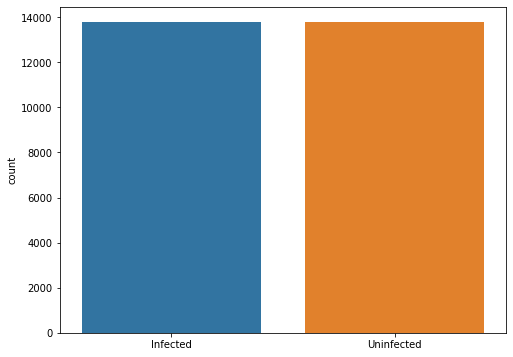

In [5]:
target=pd.Series(y, name='target')
print('Number of infected: {}'.format(target.value_counts()[0]))
print('Number of uninfected: {}'.format(target.value_counts()[1]))

figure=plt.figure(figsize=(8,6))
g1=sns.countplot(x=target)
g1.set_xticklabels(['Infected', 'Uninfected']);
g1.set_xlabel('');

Putting images into numpy arrays

In [6]:
X = np.array(X)
y = np.array(y)

Label encoding

In [7]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

Splitting data into training and testing

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y.astype(np.int8),
                                                    test_size = 0.2, random_state = 42)

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((22046, 128, 128, 3), (22046,), (5512, 128, 128, 3), (5512,))

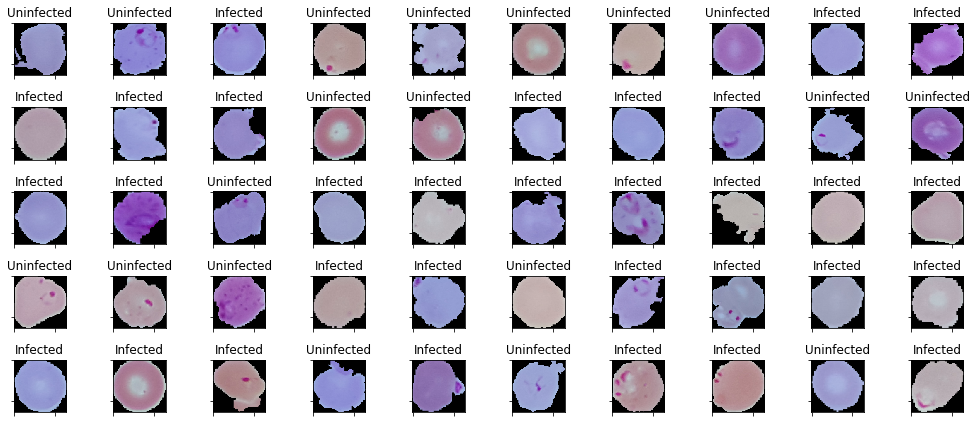

In [10]:
figure, ax = plt.subplots(5,10, figsize = (14,6))
plt.tight_layout()
for row in range(5):
    for col in range(10):
        num = np.random.randint(len(X_train))
        ax[row, col].imshow(X_train[num])
        ax[row, col].tick_params(labelleft=False, labelbottom=False)
        if y[num]==1:
            ax[row, col].set_title('Uninfected')
        else:
            ax[row, col].set_title('Infected')

Data Augmentation

In [11]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rotation_range=40,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip=True,
                                  featurewise_center=True, 
                                  featurewise_std_normalization=True,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2)

train_datagen.fit(X_train)

validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_datagen.fit(X_test)




Using TensorFlow backend.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


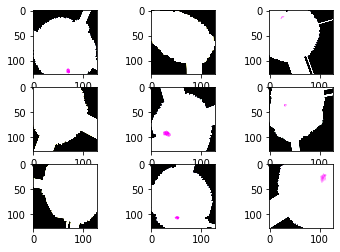

In [14]:
for x_batch, y_batch in train_datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0,9):
        plt.subplot(330 + 1 + i)
        plt.imshow(x_batch[i], cmap = plt.get_cmap('gray'))
    plt.show()
    break

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dense, Flatten, Dropout, ZeroPadding2D
from keras.layers import LeakyReLU

In [21]:
leaky_relu_alpha = 0.1

model = Sequential()

# 1st Conv Layer
model.add(Conv2D(64, (3,3), strides=(1, 1), padding='same', input_shape=(128, 128, 3)))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(BatchNormalization())

# 2nd Conv Layer
model.add(Conv2D(64, (3,3), strides=(1, 1), padding='same', input_shape=(128, 128, 3)))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(BatchNormalization())

# Max Pooling with Dropout Layer
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

# 3rd Conv Layer
model.add(Conv2D(128, (3,3), strides=(1, 1), padding='same'))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(BatchNormalization())

# 4th Conv Layer
model.add(Conv2D(128, (3,3), strides=(1, 1), padding='same'))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(BatchNormalization())

# Max Pooling with Dropout Layer
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

# 5th Conv Layer
model.add(Conv2D(256, (3,3), strides=(1, 1), padding='same'))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(BatchNormalization())

# 6th Conv Layer
model.add(Conv2D(256, (3,3), strides=(1, 1), padding='same'))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(BatchNormalization())

# Max Pooling with Dropout Layer
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

# 1st FC Dense Layer
model.add(Flatten())
model.add(Dense(256))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# 2nd FC Dense Layer
model.add(Dense(256))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Final Dense Layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)       

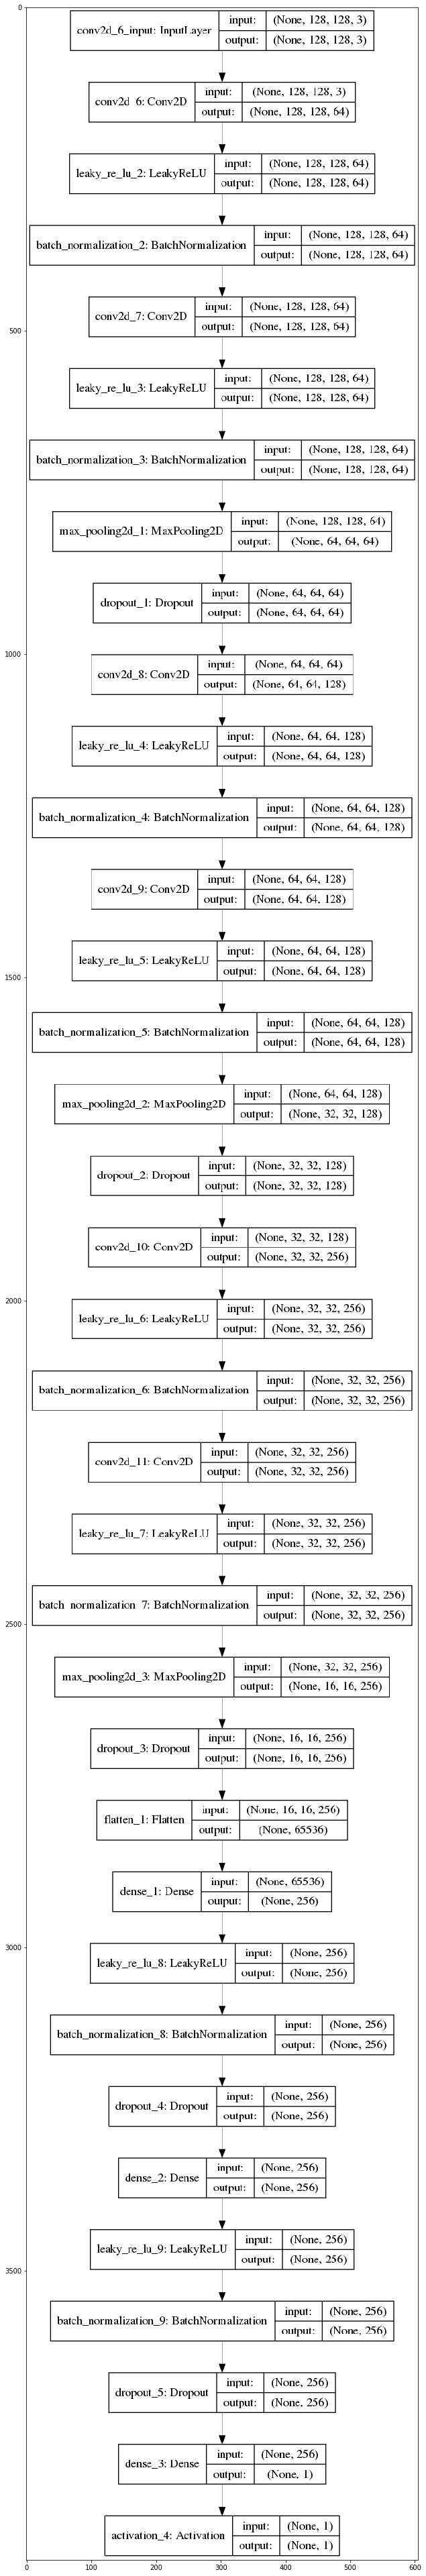

In [22]:
%matplotlib inline
import keras
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

plot_model(model, to_file='MalariaLeakyReLU.png', show_shapes = True, show_layer_names = True)
img = mpimg.imread('MalariaLeakyReLU.png')
plt.figure(figsize = (100,70))
imgplot = plt.imshow(img)

Early Stopping, Reducing LR, Checkpoint Optimzation

In [24]:
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('./Saved_Model/MalariaLeakyReLU.h5',
                            monitor = 'val_loss',
                            mode = 'min',
                            save_best_only = True,
                            verbose = 1)

earlystop = EarlyStopping(monitor = 'val_loss',
                         min_delta = 0.01,
                         patience = 15,
                         verbose = 1,
                         restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                             factor = 0.01,
                             patience = 15,
                             verbose = 1,
                             min_delta = 0.00001)

callbacks = [checkpoint, earlystop, reduce_lr]

model.compile(loss = 'binary_crossentropy',
             optimizer = Adam(lr=0.001, decay = 0.001 / 64),
             metrics = ['accuracy'])


In [25]:
epochs = 100
batch_size = 32

history = model.fit(X_train, y_train, 
                    epochs = epochs, 
                    batch_size = batch_size, 
                    validation_split = 0.2, 
                    callbacks = callbacks)

Train on 17636 samples, validate on 4410 samples
Epoch 1/100
17636/17636 [==============================] - 144s 8ms/step - loss: 0.2684 - accuracy: 0.9049 - val_loss: 0.2031 - val_accuracy: 0.9413

Epoch 00001: val_loss improved from inf to 0.20305, saving model to ./Saved_Model/MalariaLeakyReLU.h5
Epoch 2/100
17636/17636 [==============================] - 127s 7ms/step - loss: 0.1683 - accuracy: 0.9458 - val_loss: 0.1740 - val_accuracy: 0.9503

Epoch 00002: val_loss improved from 0.20305 to 0.17396, saving model to ./Saved_Model/MalariaLeakyReLU.h5
Epoch 3/100
17636/17636 [==============================] - 128s 7ms/step - loss: 0.1571 - accuracy: 0.9500 - val_loss: 0.1345 - val_accuracy: 0.9592

Epoch 00003: val_loss improved from 0.17396 to 0.13448, saving model to ./Saved_Model/MalariaLeakyReLU.h5
Epoch 4/100
17636/17636 [==============================] - 127s 7ms/step - loss: 0.1488 - accuracy: 0.9508 - val_loss: 0.1372 - val_accuracy: 0.9580

Epoch 00004: val_loss did not improve

In [ ]:
from keras.models import load_model

best_model = load_model('./Saved_Model/MalariaLeakyReLU.h5')

In [35]:
test_accuracy = best_model.evaluate(X_test, y_test, verbose = 1)

5512/5512 [==============================] - 13s 2ms/step


In [36]:
print('Accuracy in test set: {:4f}'.format(test_accuracy[1]))

Accuracy in test set: 0.963353


In [38]:
predictions = best_model.predict_classes(X_test)
confusion_matrix(predictions, y_test)

array([[2669,   74],
       [ 128, 2641]])

In [39]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2743
           1       0.97      0.95      0.96      2769

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512



In [44]:
cm = confusion_matrix(predictions, y_test)
print('Confusion Matrix: \n', cm)
sensitivity = cm[0,0]/(cm[0,0] + cm[0,1])
print('Sensitivity: {:4f} \n'.format(sensitivity))
specificity = cm[1,1]/(cm[1,0] + cm[1,1])
print('Specificity: {:4f} \n'.format(specificity))

Confusion Matrix: 
 [[2669   74]
 [ 128 2641]]
Sensitivity: 0.973022 

Specificity: 0.953774 



In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["acc"])
plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()